In [1]:
import numpyro
from tqdm import tqdm
from jax import random
from numpyro.infer import MCMC, NUTS
import numpyro.distributions as dist
from numba import jit, njit,prange
import numba as nb
from numba.numpy_support import from_dtype
from numba import njit, objmode
#numpyro.enable_x64()
#numpyro.set_platform("cpu")
#numpyro.set_host_device_count(4)
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import jax.numpy as jnp
import jax as jax
from jax import jit
jax.local_device_count()
import arviz as az
import os


gpu


/home/DIDE/sjbhatt/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


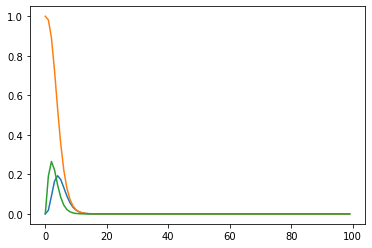

In [2]:
N = 100
n=N
x = np.linspace(start=0,stop=N-1,num=N)
def Rt(x):
    return 1.5 + np.sin(0.15*x)


samples = np.random.normal(5, 1, size=int(1e7))
samples = np.random.gamma(5, 1, size=int(1e7))

bins = np.arange(-1.0, float(N))
bins[2:] += 0.5
counts = np.histogram(samples, bins)[0]
pmf = counts / np.sum(counts)
g=pmf
g = g/np.sum(g)
G = 1-np.cumsum(g)

samples = np.random.gamma(3, 1, size=int(1e7))
bins = np.arange(-1.0, float(N))
bins[2:] += 0.5
counts = np.histogram(samples, bins)[0]
pmf = counts / np.sum(counts)
v=pmf
v = v/np.sum(v)

R=Rt(np.squeeze(x))

plt.plot(g)
plt.plot(G)
plt.plot(v)

In [3]:
@njit(parallel=True)
def quick_mean(R):
    N = np.shape(R)[0]
    F = np.zeros((N, N))
    F[:, 0] = G[0]
    for c in prange(0, N):
        for t in range(1, c+1):
            convolution = 0
            for u in range(1, t+1):
                convolution += R[c-t+u]*G[u]*v[u]*F[c, t-u]
            F[c, t] = G[t] + convolution
    return np.diag(F)
@njit(parallel=True)
def pgf(s,R,phi,T):
        p = phi/(phi+1)
        N = np.shape(R)[0]
        Fg = np.zeros((N,N))+0j
        Fg[:, 0] = s*G[0]
        for c in range(0, N):
            for t in range(1, c+1):               
                outside_integral = 0+0j
                initial_condition = 0+0j
                initial_condition_integral = 0+0j
                index = t+1
                if t+1>T:
                    index=T
                for u in range(0, index):
                    inside_integral = 0+0j
                    for k in range(0, u):
                        inside_integral +=(np.log(1-(1-p)*Fg[c, t-k]) - np.log(p)) * R[c-t+k]* v[k]
                    outside_integral += np.exp(-phi*(inside_integral)) * g[u]
                for u in range(1, index):
                    initial_condition_integral += (np.log(1-(1-p)*Fg[c, t-u]) - np.log(p)) * R[c-t+u]* v[u]
                initial_condition =  G[t] * s * np.exp(-phi*(initial_condition_integral))
                Fg[c, t] = initial_condition + outside_integral
        return np.diag(Fg)
        
@njit(parallel=True)
def compute_pmf(M,R,phi,T):
    N = np.shape(R)[0]
    num = np.zeros((M, N))+0j
    for m in prange(0, M):
        num[m, :] = np.transpose(pgf(np.exp(2.0*np.pi*1j*m/M),R,phi,T))
    pmf = np.zeros((M, N), dtype=np.float64)
    for i in prange(N):
        with objmode(out='float64[:]'):
            out = np.real(np.fft.fft(num[:, i]))
        normalise = out*(out >= 0)
        pmf[:, i] = normalise
        pmf[:, i] = pmf[:, i]/np.sum(pmf[:, i])
    return pmf
def mean(pmf):
    M = np.shape(pmf)[0]
    N = np.shape(R)[0]
    mn = np.zeros(N)
    loc = np.linspace(0, M-1, M)
    for i in range(N):
        mn[i] = np.sum(pmf[:, i]*loc)
    return mn
def CI(pmf):
    N = np.shape(R)[0]
    quant = np.zeros((N,2))
    for i in range(N):
        cdf = np.cumsum(pmf[:, i])
        quant[i,0] = np.argmax(cdf>=0.025)
        quant[i,1] = np.argmax(cdf>=0.975)
    return quant
def IQ(pmf):
    N = np.shape(R)[0]
    quant = np.zeros((N,2))
    for i in range(N):
        cdf = np.cumsum(pmf[:, i])
        quant[i,0] = np.argmax(cdf>=0.25)
        quant[i,1] = np.argmax(cdf>=0.75)
    return quant
def variance(pmf):
    M = np.shape(pmf)[0]
    N = np.shape(R)[0]
    vr = np.zeros(N)
    loc = np.linspace(0, M-1, M)
    for i in range(N):
        mn = np.sum(pmf[:, i]*loc)
        vr[i] = np.sum(pmf[:, i]*np.square(loc-mn))
    return vr
@njit(parallel=False)
def decompose_variance(R,phi,prevalence):
    N = np.shape(R)[0]
    V = np.zeros((N, N))
    V_it = np.zeros((N, N))
    V_ni = np.zeros((N, N))

    F = np.zeros((N, N))
    store1 = np.zeros((N, N))
    store2 = np.zeros((N, N))
    store3 = np.zeros((N, N))
    F[:, 0] = G[0]
    V[:, 0] = 0
    V_it[:, 0] = 0
    V_ni[:, 0] = 0
    EYsq = 1+(1/phi)
    for c in range(0, N):
        for t in range(1, c+1):
            convolution = 0
            term1=0 # G
            term2=0 # 2GM
            term3=0 # G M^2 
            term4=0 # Int Sg
            term5=0 # V
            term6=0 # MY
            term7=0 # -M^2
            term2_integral=0
            term3_integral=0
            convolutionS = 0
            term5_it=0 # V
            term5_ni=0 # V            
            for u in range(0, t+1):
                convolution +=  R[c-t+u] * G[u] * v[u] * F[c, t-u]
            if prevalence:
                F[c, t] = G[t] + convolution
            else:
                F[c, t] = 1 + convolution            
            for u in range(0,t+1):
                term4_integral = 0
                if prevalence:
                    term2_integral += R[c-t+u] * v[u] * F[c, t-u] 
                else:
                    term2_integral += R[c-t+u] * v[u] * F[c, t-u] * G[u]               
                term3_integral += R[c-t+u] * v[u] * F[c, t-u] 
                term5 += R[c-t+u] * G[u] * v[u] * V[c, t-u]
                term5_it += R[c-t+u] * G[u] * v[u] * V_it[c, t-u]
                term5_ni += R[c-t+u] * G[u] * v[u] * V_ni[c, t-u]
                term6 += R[c-t+u] * G[u] * v[u] * np.square(F[c, t-u]) * EYsq
                for q in range(0,u):
                    term4_integral += R[c-t+q] * v[q] * F[c, t-q]
                term4 += np.square(term4_integral)*g[u]
            if prevalence:
                term1 = G[t]
                term2 = 2 * G[t] * term2_integral
                term3 = np.square(term2_integral)*G[t]
            else:
                term1 = 1
                term2 = 2 * term2_integral
                term3 = np.square(term3_integral)*G[t]                
            term7 = np.square(F[c, t])
            V[c,t] = term1 + term2 + term3 + term4 + term5 + term6 - term7
            V_it[c,t] = term1 + term2 + term3 + term4 + term5_it - term7
            V_ni[c,t] = term5_ni + term6
            V[c,t] = term1 + term2 + term3 + term4 + term5 + term6 - term7
            store1[c,t] = term1 + term4 + term2 + term3  - term7
            store2[c,t] = term5
            store3[c,t] = term6 

    output = np.zeros((N,7))
    output[:,0]= np.diag(F)     
    output[:,1]= np.diag(V) 
    output[:,2]= np.diag(store1) 
    output[:,3]= np.diag(store2) 
    output[:,4]= np.diag(store3) 
    output[:,5]= np.diag(V_it)
    output[:,6]= np.diag(V_ni)
    return output      
    
def prop_decomp(decomp):
    it = decomp[:,2]
    v = decomp[:,3]
    ni = decomp[:,4]
    tot = it+v+ni
    v_it = decomp[:,5]
    v_ni = decomp[:,6]
    output = np.zeros((it.shape[0],5)) 
    output[:,0]=it/tot
    output[:,1]=v/tot
    output[:,2]=ni/tot
    output[:,3]=(v/tot)*(v_it/tot)
    output[:,4]=(v/tot)*(v_ni/tot)
    return output

In [4]:
phi=1000
pmf = compute_pmf(10000,R,phi,50)


In [5]:
decomp=decompose_variance(R,phi,True)
pd=prop_decomp(decomp)

/home/DIDE/sjbhatt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:171: RuntimeWarning: invalid value encountered in true_divide
/home/DIDE/sjbhatt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in true_divide
/home/DIDE/sjbhatt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:173: RuntimeWarning: invalid value encountered in true_divide
/home/DIDE/sjbhatt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: RuntimeWarning: invalid value encountered in true_divide
/home/DIDE/sjbhatt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: RuntimeWarning: invalid value encountered in true_divide


In [6]:
mn = mean(pmf)
vr = variance(pmf)
ci = CI(pmf)


In [7]:
s = np.append(0,np.diff(mn))
t = np.linspace(0.0, s.shape[0]-1, s.shape[0])
upper = 0
lower = 0
supper = np.ma.masked_where(s < upper, mn)
slower = np.ma.masked_where(s >= lower, mn)
supperv = np.ma.masked_where(s < upper, vr)
slowerv = np.ma.masked_where(s >= lower, vr)

supper1  = np.ma.copy(supper)
supper2 =  np.ma.copy(supper)
supper3 = np.ma.copy(supper)
slower1 = np.ma.copy(slower)
slower2 = np.ma.copy(slower)
slower3 = np.ma.copy(slower)

supper1.mask[t>40] = True
supper2.mask[t<=40] = True
supper2.mask[t>70] = True
supper3.mask[t<70] = True
slower1.mask[t>50] = True
slower2.mask[t<=50] = True

supper1v  = np.ma.copy(supperv)
supper2v =  np.ma.copy(supperv)
supper3v = np.ma.copy(supperv)
slower1v = np.ma.copy(slowerv)
slower2v = np.ma.copy(slowerv)
slower3v = np.ma.copy(slowerv)

supper1v.mask[t>40] = True
supper2v.mask[t<=40] = True
supper2v.mask[t>70] = True
supper3v.mask[t<70] = True
slower1v.mask[t>50] = True
slower2v.mask[t<=50] = True

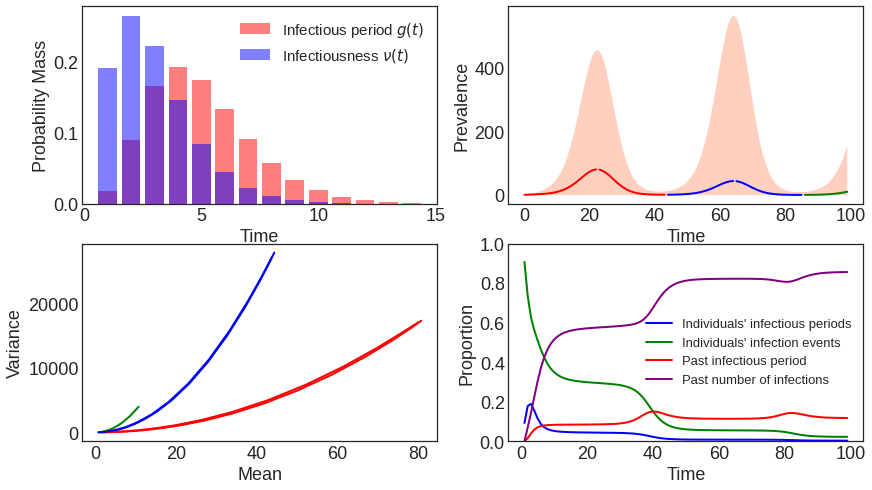

In [12]:
import matplotlib.style
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
mpl.style.use('seaborn-white')
env = 'orangered'


SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE) 


fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
Tr=15
ax1.bar(x[1:Tr],g[1:Tr],color='red',alpha=0.5,label="Infectious period $g(t)$")
ax1.bar(x[1:Tr],v[1:Tr],color='blue',alpha=0.5,label="Infectiousness $\\nu(t)$")
ax1.set_xlabel("Time")
ax1.set_ylabel("Probability Mass")
ax1.legend(loc='upper right',fancybox=True,ncol=1)

ax2.plot(t,supper1,color='red',linewidth=2)
ax2.plot(t,supper2,color='blue',linewidth=2)
ax2.plot(t,supper3,color='green',linewidth=2)
ax2.plot(t,slower1,color='red',linewidth=2)
ax2.plot(t,slower2,color='blue',linewidth=2)
ax2.fill_between(x, ci[:,0], ci[:,1], facecolor=env, alpha=0.25)
ax2.ticklabel_format(useOffset=False)
ax2.set_xlabel("Time")
ax2.set_ylabel("Prevalence")
ax2.legend(loc='upper left',fancybox=True,ncol=1)

ax3.plot(supper1,supper1v,color='red',linewidth=2)
ax3.plot(supper2,supper2v,color='blue',linewidth=2)
ax3.plot(supper3,supper3v,color='green',linewidth=2)
ax3.plot(slower1,slower1v,color='red',linewidth=2)
ax3.plot(slower2,slower2v,color='blue',linewidth=2)
ax3.set_xlabel("Mean")
ax3.set_ylabel("Variance")

ax4.plot(x,pd[:,0],alpha=1,color='blue',label="Individuals' infectious periods",linewidth=2)
ax4.plot(x,pd[:,2],alpha=1,color='green',label="Individuals' infection events",linewidth=2)
ax4.plot(x,pd[:,3],alpha=1,color='red',label="Past infectious period",linewidth=2)
ax4.plot(x,pd[:,4],alpha=1,color='purple',label="Past number of infections",linewidth=2)
ax4.set_xlabel("Time")
ax4.set_ylim(0,1)
ax4.set_ylabel("Proportion")
ax4.legend(loc='center right',fancybox=True,ncol=1,bbox_to_anchor=(1, 0.45), prop={'size': 13})



savefigurepath = '/home/DIDE/sjbhatt/BH_notebooks/new paper/Figure0.pdf'
plt.savefig(savefigurepath,bbox_inches='tight')

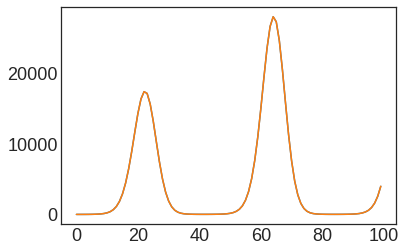

In [9]:
plt.plot(decompose_variance(R,phi,True)[:,1])
plt.plot(vr)